In [47]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from skimpy import skim

from scipy.stats import norm
import statsmodels.api as sm

from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import TargetEncoder
from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              GradientBoostingClassifier,
                              HistGradientBoostingClassifier)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import (confusion_matrix,
                             accuracy_score,
                             precision_recall_curve,
                             classification_report)

from collections import Counter
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")

In [12]:
!pip install catboost skimpy

!pip install -U scikit-learn
!pip install feature_engine

In [13]:
df = pd.read_csv('/content/ad_10000records.csv')
df.head()

AttributeError: 'Index' object has no attribute '_format_flat'

   Daily Time Spent on Site   Age  Area Income  Daily Internet Usage  \
0                     62.26  32.0     69481.85                172.83   
1                     41.73  31.0     61840.26                207.17   
2                     44.40  30.0     57877.15                172.83   
3                     59.88  28.0     56180.93                207.17   
4                     49.21  30.0     54324.73                201.58   

                         Ad Topic Line             City  Gender  \
0      Decentralized real-time circuit         Lisafort    Male   
1       Optional full-range projection  West Angelabury    Male   
2  Total 5thgeneration standardization        Reyesfurt  Female   
3          Balanced empowering success      New Michael  Female   
4  Total 5thgeneration standardization     West Richard  Female   

                        Country            Timestamp  Clicked on Ad  
0  Svalbard & Jan Mayen Islands  2016-06-09 21:43:05              0  
1                     Si

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  10000 non-null  float64
 1   Age                       10000 non-null  float64
 2   Area Income               10000 non-null  float64
 3   Daily Internet Usage      10000 non-null  float64
 4   Ad Topic Line             10000 non-null  object 
 5   City                      10000 non-null  object 
 6   Gender                    10000 non-null  object 
 7   Country                   10000 non-null  object 
 8   Timestamp                 10000 non-null  object 
 9   Clicked on Ad             10000 non-null  int64  
dtypes: float64(4), int64(1), object(5)
memory usage: 781.4+ KB


In [15]:
df.shape

(10000, 10)

In [16]:
print(df.duplicated().sum())

215


In [17]:
df.drop_duplicates(inplace=True)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9785 entries, 0 to 9998
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  9785 non-null   float64
 1   Age                       9785 non-null   float64
 2   Area Income               9785 non-null   float64
 3   Daily Internet Usage      9785 non-null   float64
 4   Ad Topic Line             9785 non-null   object 
 5   City                      9785 non-null   object 
 6   Gender                    9785 non-null   object 
 7   Country                   9785 non-null   object 
 8   Timestamp                 9785 non-null   object 
 9   Clicked on Ad             9785 non-null   int64  
dtypes: float64(4), int64(1), object(5)
memory usage: 840.9+ KB


In [25]:
df.columns

Index(['Daily Time Spent on Site', 'Age', 'Area Income',
       'Daily Internet Usage', 'Ad Topic Line', 'City', 'Gender', 'Country',
       'Timestamp', 'Clicked on Ad'],
      dtype='object')

EDA

In [21]:
df = df.reset_index(drop=True)


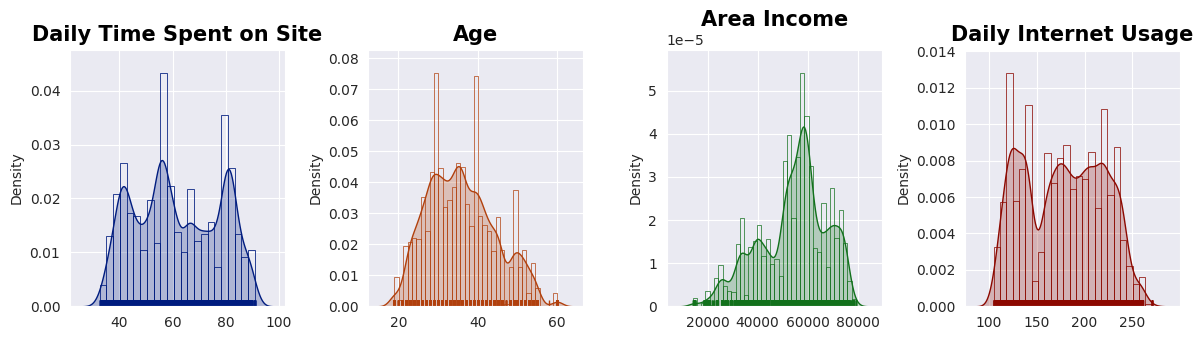

In [27]:
sns.set_style(style = "darkgrid")
colors = sns.color_palette(palette = 'dark', n_colors = 4)

numerical_columns = ['Daily Time Spent on Site',
                      'Age',
                      'Area Income',
                      'Daily Internet Usage']

fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize = (12, 3.5))
axs = axs.flat

# Reset the index of the DataFrame to ensure it is in a proper format
df = df.reset_index(drop=True)  # Ensure the DataFrame index is properly set

for i,col in enumerate(numerical_columns):
    # Explicitly pass the column data to histplot
    sns.histplot(df[col], stat = 'density', color = colors[i], fill = False, ax = axs[i])
    sns.rugplot(df[col], color = colors[i], ax = axs[i])
    sns.kdeplot(df[col], color = colors[i], fill = True, ax = axs[i])
    axs[i].set_xlabel("")
    axs[i].set_title(f"{col}", fontsize = 15, fontweight = 'bold', color = 'black')

fig.tight_layout()
fig.show()

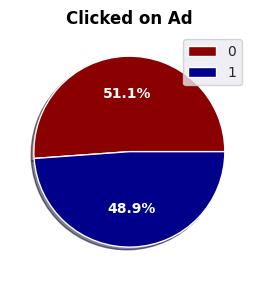

In [30]:
plt.figure(figsize = (4, 3.1))
plt.pie(x = list(Counter(df['Clicked on Ad']).values()),
        labels = list(Counter(df['Clicked on Ad']).keys()),
        colors = ["darkred", "darkblue"],
        autopct = "%.1f%%",
        shadow = True,
        textprops = {'fontsize':10, 'fontweight':'bold', 'color':'white'})
plt.legend(loc = 'upper right')
plt.title("Clicked on Ad", fontsize = 12, fontweight = "bold", color = "black")
plt.show()

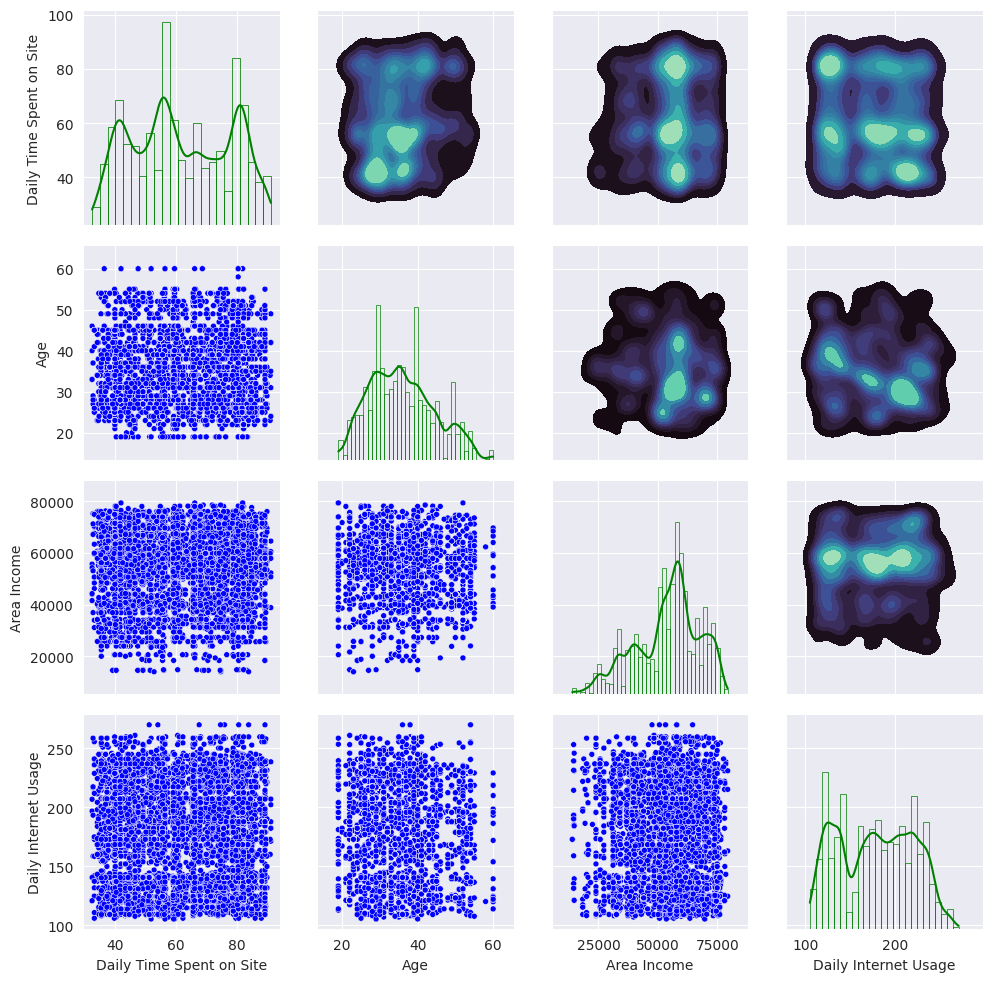

In [32]:
g = sns.PairGrid(df[numerical_columns], palette = "dark")
g.map_lower(sns.scatterplot, size = 3, color = 'blue')
g.map_diag(sns.histplot,
           color = 'green',
           fill = False,
           kde = True)
g.map_upper(sns.kdeplot, fill = True, cmap = 'mako')
g.fig.show()

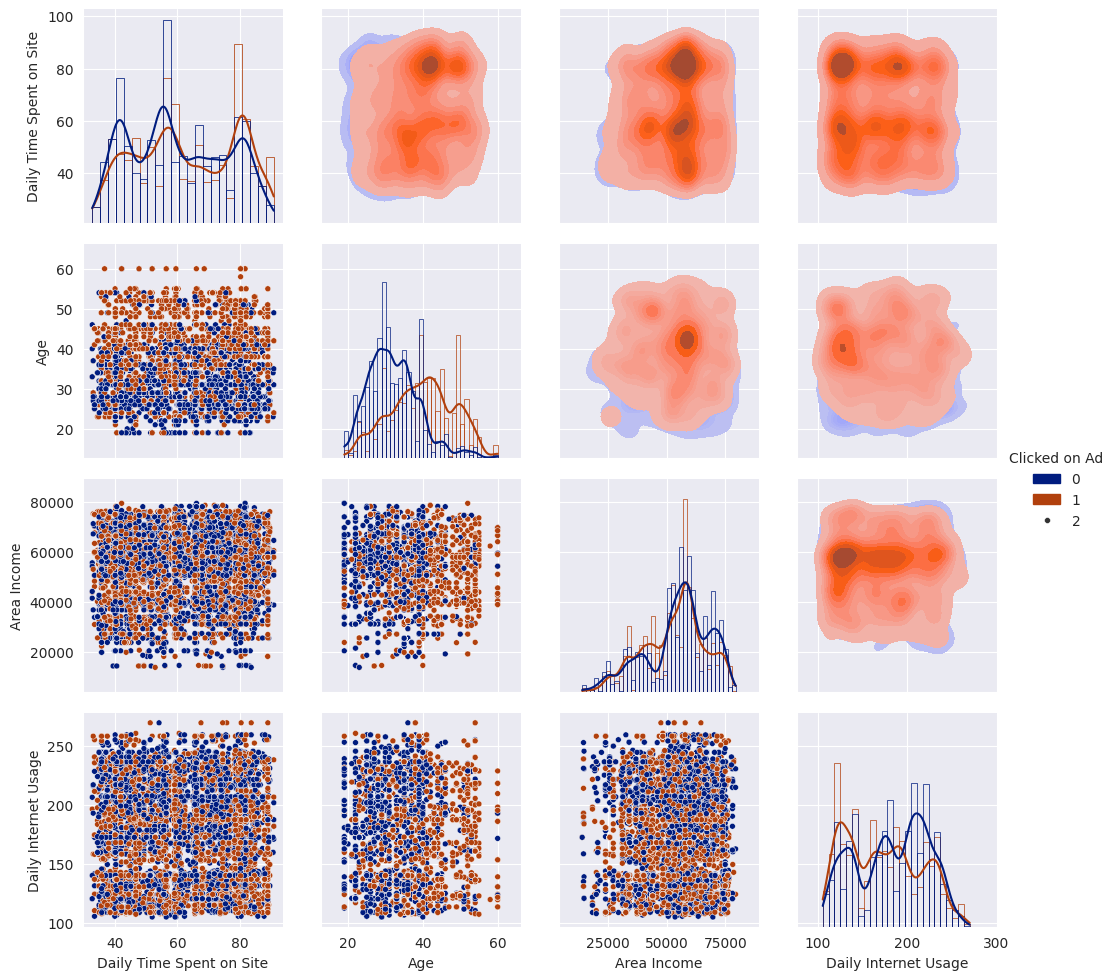

In [34]:
g = sns.PairGrid(df, hue = 'Clicked on Ad', palette = "dark")
g.map_lower(sns.scatterplot, size = 2)
g.map_diag(sns.histplot,
           fill = False,
           kde = True)
g.map_upper(sns.kdeplot, fill = True)
g.add_legend()
g.fig.show()

Feature eanginearin

In [37]:
# Extract hour from timestamp
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Hour'] = df['Timestamp'].dt.hour
df['Day'] = df['Timestamp'].dt.day
df['Month'] = df['Timestamp'].dt.month
df.drop('Timestamp', axis=1, inplace=True)

In [ ]:
X = df.drop(['Clicked on Ad'], axis=1)
y = df['Clicked on Ad']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [39]:
# Calculate overall CTR for previous ads (rolling average over 3 days)
df['PrevAdCTR'] = df['Clicked on Ad'].shift().rolling(window=3).mean()


In [40]:
df['Age_TimeSpent'] = df['Age'] * df['Daily Time Spent on Site']


Feature Engineering Report

1. Extracting Hour from Timestamp
- We converted the 'Timestamp' column to datetime format.
- Extracted the hour, day, and month from the timestamp.
- Removed the original timestamp column.

2. Train-Test Split
- Split the dataset into training and testing sets for model evaluation.

3. Previous Ad Click-Through Rate (CTR)
- Calculated the rolling average CTR over the past 3 days.
- Helps capture trends in ad engagement and user behavior.

4. Age × Time Spent on Site
- Created a new feature by multiplying 'Age' with 'Daily Time Spent on Site.'
- Captures potential interactions between age and browsing behavior.

Significance:
- Extracting hour, day, and month allows us to account for time-related patterns in ad interactions.
- The rolling average CTR provides context on recent ad performance.
- The 'Age_TimeSpent' feature explores how age and time spent on the site jointly impact ad engagement.

In [41]:
!pip install scikit-learn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from feature_engine.creation import CyclicalFeatures

categorical_columns = ['Gender', 'Country', 'City', 'Ad Topic Line']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

time_columns = ['Hour', 'Day', 'Month']
cyclical_transformer = Pipeline(steps=[
    ('cyclical', CyclicalFeatures(variables=time_columns, drop_original=True))
])

numerical_features = ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage']
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

1. Extracting Hour, Day, and Month from Timestamp
- We converted the 'Timestamp' column to datetime format.
- Extracted the hour, day, and month components.
- These features allow us to account for time-related patterns in ad interactions.

2. Handling Categorical Variables
- We addressed categorical columns ('Gender', 'Country', 'City', 'Ad Topic Line').
- Imputed missing values with 'missing' and applied one-hot encoding.
- Helps incorporate categorical information into the model.

3. Cyclical Encoding for Time Columns
- We transformed time-related columns ('Hour', 'Day', 'Month') using cyclical features.
- Captures cyclic patterns (e.g., daily or monthly) without imposing linearity.

4. Imputing and Scaling Numerical Features
- We handled numerical features ('Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage').
- Imputed missing values with the mean.
- Scaled features to a common range (MinMax scaling).

Significance:
- These engineered features enhance model performance by capturing relevant patterns and ensuring consistent scaling.


In [44]:
X = df.drop(['Clicked on Ad'], axis=1)
y = df['Clicked on Ad']
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3, random_state=42)

In [48]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns),
        ('time', cyclical_transformer, time_columns)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8746594005449592
Confusion Matrix:
 [[1353  165]
 [ 203 1215]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.89      0.88      1518
           1       0.88      0.86      0.87      1418

    accuracy                           0.87      2936
   macro avg       0.87      0.87      0.87      2936
weighted avg       0.87      0.87      0.87      2936



Feature Engineering and Model Evaluation Report

Feature Engineering Steps

1. Extracting Hour, Day, and Month from Timestamp:
   - We converted the 'Timestamp' column to datetime format.
   - Extracted the hour, day, and month components.
   - These features allow us to account for time-related patterns in ad interactions.

2. Handling Categorical Variables:
   - Addressed categorical columns ('Gender', 'Country', 'City', 'Ad Topic Line').
   - Imputed missing values with 'missing' and applied one-hot encoding.
   - Helps incorporate categorical information into the model.

3. Cyclical Encoding for Time Columns:
   - Transformed time-related columns ('Hour', 'Day', 'Month') using cyclical features.
   - Captures cyclic patterns (e.g., daily or monthly) without imposing linearity.

4. Imputing and Scaling Numerical Features:
   - Handled numerical features ('Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage').
   - Imputed missing values with the mean.
   - Scaled features to a common range (MinMax scaling).

Model Evaluation Results

- Random Forest Classifier:
  - Trained the model using the preprocessed features.
  - Achieved an accuracy of approximately 87.47% on the test set.


Analysis

- The Random Forest model performs well, achieving balanced precision and recall for both classes.
- The cyclical encoding of time features allows us to capture cyclic patterns without introducing linearity assumptions.
- Further exploration could involve hyperparameter tuning and experimenting with other classifiers.



In [49]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

param_grid_xgb = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0]
}

grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5, n_jobs=1, scoring='accuracy', verbose=2)

grid_search_xgb.fit(X_train, y_train)

y_pred_xgb = grid_search_xgb.predict(X_test)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END classifier__colsample_bytree=0.6, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.6; total time=   1.0s
[CV] END classifier__colsample_bytree=0.6, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.6; total time=   2.9s
[CV] END classifier__colsample_bytree=0.6, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.6; total time=   1.2s
[CV] END classifier__colsample_bytree=0.6, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.6; total time=   1.6s
[CV] END classifier__colsample_bytree=0.6, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.6; total time=   0.2s
[CV] END classifier__colsample_bytree=0.6, classifier__l

In [50]:
print("Best Parameters (XGBoost):", grid_search_xgb.best_params_)
print("Accuracy (XGBoost):", accuracy_score(y_test, y_pred_xgb))
print("Confusion Matrix (XGBoost):\n", confusion_matrix(y_test, y_pred_xgb))
print("Classification Report (XGBoost):\n", classification_report(y_test, y_pred_xgb))

Best Parameters (XGBoost): {'classifier__colsample_bytree': 0.6, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 300, 'classifier__subsample': 0.8}
Accuracy (XGBoost): 0.875
Confusion Matrix (XGBoost):
 [[1333  185]
 [ 182 1236]]
Classification Report (XGBoost):
               precision    recall  f1-score   support

           0       0.88      0.88      0.88      1518
           1       0.87      0.87      0.87      1418

    accuracy                           0.88      2936
   macro avg       0.87      0.87      0.87      2936
weighted avg       0.88      0.88      0.88      2936



 Feature Engineering and XGBoost Model Evaluation Report

 Feature Engineering Recap

1. Extracting Hour, Day, and Month from Timestamp:
   - We converted the 'Timestamp' column to datetime format.
   - Extracted the hour, day, and month components.
   - These features allow us to account for time-related patterns in ad interactions.

2. Handling Categorical Variables:
   - Addressed categorical columns ('Gender', 'Country', 'City', 'Ad Topic Line').
   - Imputed missing values with 'missing' and applied one-hot encoding.
   - Helps incorporate categorical information into the model.

3. Cyclical Encoding for Time Columns:
   - Transformed time-related columns ('Hour', 'Day', 'Month') using cyclical features.
   - Captures cyclic patterns (daily or monthly) without imposing linearity.

4. Imputing and Scaling Numerical Features
   - Handled numerical features ('Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage').
   - Imputed missing values with the mean.
   - Scaled features to a common range (MinMax scaling).

XGBoost Model Results

- Best Parameters (XGBoost):
  {'classifier__colsample_bytree': 0.6,
   'classifier__learning_rate': 0.1,
   'classifier__max_depth': 7,
   'classifier__n_estimators': 300,
   'classifier__subsample': 0.8}
  
- Accuracy (XGBoost): 87.5%
- Confusion Matrix (XGBoost):

  [[1333  185]
   [ 182 1236]]
  
- Classification Report (XGBoost):
                precision    recall  f1-score   support

           0       0.88      0.88      0.88      1518
           1       0.87      0.87      0.87      1418

    accuracy                           0.88      2936
   macro avg       0.87      0.87      0.87      2936
weighted avg       0.88      0.88      0.88      2936

Analysis

- The XGBoost model performs well, achieving balanced precision and recall for both classes.
- Feature engineering enhances model performance by capturing relevant patterns.
- Further exploration could involve hyperparameter tuning and experimenting with other classifiers.
